
# Intro


**Notes**

The main bulk of the material comes from https://developers.google.com/machine-learning/recommendation/overview/candidate-generation. If you want to go further later, you can take a look at http://nicolas-hug.com/blog/matrix_facto_3. It is absolutely not expected to look at these two links for the interviews  or to complete the test.

**Context**: 

We want to build a movies' recommender in order to get new movies to watch during the lock down. We will base our work on a variation of the MovieLens dataset. 
The data consists of movies seen by the users, some informations about the movies, and some informations about the users. The problem consists in predicting which movies a given user might like.

We are presenting you here first a naive approach in order to familarize yourself with the problem and show you how it might be solved.

**Task**:

The code presented is a first implementation but has a number of shortcomings in its structure and features (more on that in the conclusion). Your task consist in producing a refactoring, so as to be one step closer to a "clean" code.

**Evaluation**:

Our goal here is two fold:
- See how you understand a problem and adapt to an already given approach to tackle it.
- See how you can design new features.
- See how you manipulate python code: understanding, ideas to refactor etc ...

The projects will be evaluated on the quality of the source code produced.

# The data

First, let's load some data.

In [1]:


import pandas as pd

users = pd.read_csv("data/users.csv")
print(users.shape)
users.head()

(6040, 5)


,user_id,gender,age,occupation,zip_code
0,0,F,1,10,48067
1,1,M,56,16,70072
2,2,M,25,15,55117
3,3,M,45,7,02460
4,4,M,25,20,55455


In [3]:
movies = pd.read_csv("data/movies.csv")
movies.head()

,movie_id,title,year,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,...,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,0,Toy Story,1995,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Jumanji,1995,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Grumpier Old Men,1995,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Waiting to Exhale,1995,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Father of the Bride Part II,1995,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
ratings = pd.read_csv("data/ratings.csv")
ratings.head()

,user_id,movie_id,rating
0,0,1192,5
1,0,660,3
2,0,913,3
3,0,3407,4
4,0,2354,5


# Content-based Filtering

Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback. We dont use other users information !

For example, if user `A` liked `Harry Potter 1`, he/she will like `Harry Potter 2`

In [5]:
%%html
<img src='https://miro.medium.com/max/1642/1*BME1JjIlBEAI9BV5pOO5Mg.png' height="300" width="250"/>

What are similar movies ? In order to answer to this question we need to build a similiarity measure. 

## Features

This measure will operate on the characteristics (**features**) of the movies to determine which are close. In our case, we have access to the genres of the movies. For example, the genres of `Toy Story` are: `Animation`, `Children's` and `Comedy`. This is represented as follow in our dataset:

In [6]:
#Storing genres in genre_cols.  

genre_cols = ["Animation", "Children's", 
       'Comedy', 'Adventure', 'Fantasy', 'Romance', 'Drama',
       'Action', 'Crime', 'Thriller', 'Horror', 'Sci-Fi', 'Documentary', 'War',
       'Musical', 'Mystery', 'Film-Noir', 'Western']

genre_and_title_cols = ['title'] + genre_cols 

movies[genre_and_title_cols].head()

,title,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,Toy Story,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Jumanji,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Grumpier Old Men,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Waiting to Exhale,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Father of the Bride Part II,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Similarity

Now that we have some features, we will try to find a function that performs a similiarity measure. The Similarity function will take two items (two list of features) and return a number proportional to their similarity. 

For the following we will consider that the Similarity between two movies is the number of genres they have in common.

Here is an example with `Toy Story` and `E.T`

In [121]:
movies[genre_and_title_cols].loc[movies.title == 'Toy Story'][genre_cols]

,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
toy_story_genres = movies[genre_and_title_cols].loc[movies.title == 'Toy Story'][genre_cols].iloc[0]
toy_story_genres

Animation      1.0
Children's     1.0
Comedy         1.0
Adventure      0.0
Fantasy        0.0
Romance        0.0
Drama          0.0
Action         0.0
Crime          0.0
Thriller       0.0
Horror         0.0
Sci-Fi         0.0
Documentary    0.0
War            0.0
Musical        0.0
Mystery        0.0
Film-Noir      0.0
Western        0.0
Name: 0, dtype: float64

In [8]:
et_genres = movies[genre_and_title_cols].loc[movies.title == 'E.T. the Extra-Terrestrial'][genre_cols].iloc[0]
et_genres

Animation      0.0
Children's     1.0
Comedy         0.0
Adventure      0.0
Fantasy        1.0
Romance        0.0
Drama          1.0
Action         0.0
Crime          0.0
Thriller       0.0
Horror         0.0
Sci-Fi         1.0
Documentary    0.0
War            0.0
Musical        0.0
Mystery        0.0
Film-Noir      0.0
Western        0.0
Name: 1081, dtype: float64

In [9]:
et_genres.values * toy_story_genres

Animation      0.0
Children's     1.0
Comedy         0.0
Adventure      0.0
Fantasy        0.0
Romance        0.0
Drama          0.0
Action         0.0
Crime          0.0
Thriller       0.0
Horror         0.0
Sci-Fi         0.0
Documentary    0.0
War            0.0
Musical        0.0
Mystery        0.0
Film-Noir      0.0
Western        0.0
Name: 0, dtype: float64

In [10]:
(et_genres.values * toy_story_genres).sum() # scalar product

1.0

So our similarity measure returns `1.0` for these two movies. 

Let's see another example where we compare `Toy Stories` and `Pocahontas`

In [11]:
pocahontas_genres = movies[genre_and_title_cols].loc[movies.title == 'Pocahontas'][genre_cols].iloc[0]
(pocahontas_genres.values * toy_story_genres).sum()

2.0

This tels us that `Pocahontas` is closer to `Toy Stories` than `E.T.` which makes sense.


## Scaling up

Ok, that's a nice measure. Now we are going to scale it up to all movies of our dataset. To do so smartly, let's take a look at the operation we just did, but from a mathematical point of view. To do so, we will think of the list of features of a movie as a vector `V`. Then, our similarity measure between `Toy Story` and `E.T.` becomes:
$ V_{ToyStory} \cdot V_{ET}^{T}$

More generally the similarity measure between a movie `i` and another movie `j` is : $ V_{i} \cdot V_{j}^{T}$

Now we can think of `movies` as a matrix containing all features vectors describing the movies. Here is how our similiarity measure looks in this context:

![](imgs/dot_product_matrices.png)

To obtain the similiarity between all movies of our dataset we have to perform the dot product of the `movies` matrix with the transposed of the `movies` matrix.

In [12]:
similarity = movies[genre_cols].values.dot(movies[genre_cols].values.T)
similarity.shape

(3883, 3883)

We can now get the similarity between `Toy Story` and any other movie of our dataset

In [13]:
similarity_with_toy_story = similarity[0] # 0 is Toy Story
similarity_with_toy_story

array([3., 1., 1., ..., 0., 0., 0.])

In [14]:
for i in range(10):
    print(f"Similarity between Toy story and {movies.iloc[i]['title']} (index {i}) is {similarity_with_toy_story[i]}")

Similarity between Toy story and Toy Story (index 0) is 3.0
Similarity between Toy story and Jumanji (index 1) is 1.0
Similarity between Toy story and Grumpier Old Men (index 2) is 1.0
Similarity between Toy story and Waiting to Exhale (index 3) is 1.0
Similarity between Toy story and Father of the Bride Part II (index 4) is 1.0
Similarity between Toy story and Heat (index 5) is 0.0
Similarity between Toy story and Sabrina (index 6) is 1.0
Similarity between Toy story and Tom and Huck (index 7) is 1.0
Similarity between Toy story and Sudden Death (index 8) is 0.0
Similarity between Toy story and GoldenEye (index 9) is 0.0


## A bit of polishing

### Helpers:

We also built some helpers to handle the movies dataset:

In [15]:
from content_based_filtering.helpers.movies import get_movie_id, get_movie_name, get_movie_year
    
print (get_movie_id(movies, 'Toy Story'))
print (get_movie_id(movies, 'Die Hard'))

print (get_movie_name(movies, 0))
print (get_movie_name(movies, 1000))
print (get_movie_year(movies, 1000))

0
1023
Toy Story
Parent Trap, The
1961


### Finding similar movies:
Here is a method giving us the movie the most similar to another movie:

In [16]:
def get_most_similar(similarity, movie_name, year=None, top=10):
    index_movie = get_movie_id(movies, movie_name, year)
    best = similarity[index_movie].argsort()[::-1]
    return [(ind, get_movie_name(movies, ind), similarity[index_movie, ind]) for ind in best[:top] if ind != index_movie]

In [17]:
get_most_similar(similarity, 'Toy Story')

[(667, 'Space Jam', 3.0),
 (3685, 'Adventures of Rocky and Bullwinkle, The', 3.0),
 (3682, 'Chicken Run', 3.0),
 (2009, 'Jungle Book, The', 3.0),
 (2011, 'Lady and the Tramp', 3.0),
 (2012, 'Little Mermaid, The', 3.0),
 (2033, 'Steamboat Willie', 3.0),
 (2072, 'American Tail, An', 3.0),
 (2073, 'American Tail: Fievel Goes West, An', 3.0)]

In [18]:
get_most_similar(similarity, 'Psycho', 1960) 

[(3593, "Puppet Master III: Toulon's Revenge", 2.0),
 (2923, 'Rawhead Rex', 2.0),
 (1312, 'Believers, The', 2.0),
 (3407, "Jacob's Ladder", 2.0),
 (1957, 'Disturbing Behavior', 2.0),
 (1927, 'Poltergeist III', 2.0),
 (1926, 'Poltergeist II: The Other Side', 2.0),
 (1925, 'Poltergeist', 2.0),
 (732, 'Thinner', 2.0),
 (69, 'From Dusk Till Dawn', 2.0)]

### Giving a recommendation:

And finally, let's find some movies to recommend based on previously liked movies:

In [19]:
def get_recommendations(user_id):
    top_movies = ratings[ratings['user_id'] == user_id].sort_values(by='rating', ascending=False).head(3)['movie_id']
    index=['movie_id', 'title', 'similarity']

    most_similars = []
    for top_movie in top_movies:
        most_similars += get_most_similar(similarity, get_movie_name(movies, top_movie), get_movie_year(movies, top_movie))

    return pd.DataFrame(most_similars, columns=index).drop_duplicates().sort_values(by='similarity', ascending=False).head(5)

get_recommendations(0)


,movie_id,title,similarity
0,957,"African Queen, The",4.0
1,1630,Starship Troopers,4.0
2,2253,Soldier,4.0
3,1178,Star Wars: Episode V - The Empire Strikes Back,4.0
26,2072,"American Tail, An",3.0


In [20]:
get_recommendations(1000)

,movie_id,title,similarity
0,69,From Dusk Till Dawn,3.0
1,1599,"Devil's Advocate, The",3.0
2,2757,"13th Warrior, The",2.0
3,3701,Dreamscape,2.0
4,2044,Graveyard Shift,2.0


# Conclusion:

The code presented is a first implementation but has a number of shortcomings preventing the collaboration of multiple MLE and Data Scientists:
- It is not possible to introduce easily new features mainly because the code is just a bunch of functions in one file.
- The code can not be scaled to other datasets or variations of the tasks.
- There is no evaluation of the performances.
- There is no testing

Additionaly a number we could think of some features to add, for example, what about looking at similar users to find a recommendation for our targeted user ?

In [140]:
#importing libraries: 

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')


In [138]:
#Mering movies and ratings based on common key movie_id:
df = pd.merge(ratings,movies,on = 'movie_id')
df.head()


,user_id,movie_id,rating,title,year,Animation,Children's,Comedy,Adventure,Fantasy,...,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,0,1192,5,One Flew Over the Cuckoo's Nest,1975,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1192,5,One Flew Over the Cuckoo's Nest,1975,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11,1192,4,One Flew Over the Cuckoo's Nest,1975,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14,1192,4,One Flew Over the Cuckoo's Nest,1975,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16,1192,5,One Flew Over the Cuckoo's Nest,1975,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [145]:
df['rating'].value_counts()
df.columns

Index(['user_id', 'movie_id', 'rating', 'title', 'year', 'Animation',
       'Children's', 'Comedy', 'Adventure', 'Fantasy', 'Romance', 'Drama',
       'Action', 'Crime', 'Thriller', 'Horror', 'Sci-Fi', 'Documentary', 'War',
       'Musical', 'Mystery', 'Film-Noir', 'Western'],
      dtype='object')

### Exploratory data analysis:

#### Creating a rating dataframe with avg ratings and number of ratings

In [146]:
#This returns average rating for title. - Doesn't gurantee highest rated title. 
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()


title
Ulysses (Ulisse)                      5.0
Schlafes Bruder (Brother of Sleep)    5.0
Smashing Time                         5.0
Song of Freedom                       5.0
Gate of Heavenly Peace, The           5.0
Name: rating, dtype: float64

In [147]:
# Sorted values based on number of user ratings 
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
American Beauty                                   3428
Star Wars: Episode IV - A New Hope                2991
Star Wars: Episode V - The Empire Strikes Back    2990
Star Wars: Episode VI - Return of the Jedi        2883
Jurassic Park                                     2672
Name: rating, dtype: int64

In [162]:
#creating a dataframe with average ratings for title
r_ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
r_ratings.head()

,rating
title,
"$1,000,000 Duck",3.027027
'Night Mother,3.371429
'Til There Was You,2.692308
"'burbs, The",2.910891
...And Justice for All,3.713568


In [163]:
#creating a dataframe with number of ratings for title
r_ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
r_ratings.head()


,rating,num of ratings
title,,
"$1,000,000 Duck",3.027027,37
'Night Mother,3.371429,70
'Til There Was You,2.692308,52
"'burbs, The",2.910891,303
...And Justice for All,3.713568,199


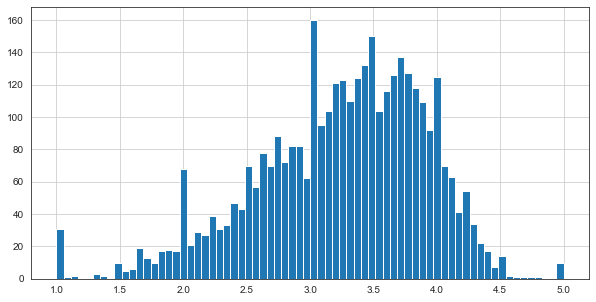

In [174]:
plt.figure(figsize=(10,5))
r_ratings['rating'].hist(bins=70)

### Recommending similar movies

##### Using 'user_id' as key so that each row will consist rating for each user. 

In [178]:
moviemat = df.pivot_table(index = 'user_id', columns='title', values = 'rating')
moviemat.head()

title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kj�rlighetens kj�tere),Zeus and Roxanne,eXistenZ
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [181]:
#Most rated movies: 
r_ratings.sort_values('num of ratings', ascending = False).head(10)

,rating,num of ratings
title,,
American Beauty,4.317386,3428
Star Wars: Episode IV - A New Hope,4.453694,2991
Star Wars: Episode V - The Empire Strikes Back,4.292977,2990
Star Wars: Episode VI - Return of the Jedi,4.022893,2883
Jurassic Park,3.763847,2672
Saving Private Ryan,4.337354,2653
Terminator 2: Judgment Day,4.058513,2649
"Matrix, The",4.315830,2590
Back to the Future,3.990321,2583


In [194]:
# Let's choose two movies: American Beauty a comedy and Matrix The a thriller
r_ratings.head()

,rating,num of ratings
title,,
"$1,000,000 Duck",3.027027,37
'Night Mother,3.371429,70
'Til There Was You,2.692308,52
"'burbs, The",2.910891,303
...And Justice for All,3.713568,199


In [196]:
# Now grab the user ratings for two movies
AB_user_ratings = moviemat['American Beauty']
Matrix_user_ratings = moviemat['Matrix, The']
AB_user_ratings.head()

user_id
0    NaN
1    4.0
2    4.0
3    NaN
4    4.0
Name: American Beauty, dtype: float64

##### We can use corrwith() method to get corr between two pandas series

In [197]:
similar_to_AB = moviemat.corrwith(AB_user_ratings)
similar_to_Matrix = moviemat.corrwith(Matrix_user_ratings)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


##### Clean by removing Nan values and using a Dataframe instead of Series

In [198]:
corr_AB = pd.DataFrame(similar_to_AB,columns=['Correlation'])
corr_AB.dropna(inplace=True)
corr_AB.head()

,Correlation
title,
"$1,000,000 Duck",-0.193080
'Night Mother,0.318625
'Til There Was You,0.064574
"'burbs, The",0.142070
...And Justice for All,0.182361


#### Sort the dataframe by corr then get similar movies however some results really don't make sense. Because lot of movies only watched once

In [199]:
corr_AB.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Six of a Kind,1.0
"Paralyzing Fear: The Story of Polio in America, A",1.0
In God's Hands,1.0
"Cabinet of Dr. Ramirez, The",1.0
"James Dean Story, The",1.0
American Beauty,1.0
Intimate Relations,1.0
Conceiving Ada,1.0
Home Page,1.0


##### Filtering out movies that have less tahn 100 reviews (histo)

In [201]:
corr_AB = corr_AB.join(r_ratings['num of ratings'])
corr_AB.head()

,Correlation,num of ratings
title,,
"$1,000,000 Duck",-0.193080,37
'Night Mother,0.318625,70
'Til There Was You,0.064574,52
"'burbs, The",0.142070,303
...And Justice for All,0.182361,199


In [202]:
# Now sort the values and see how it looks
corr_AB[corr_AB['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
American Beauty,1.000000,3428
All the King's Men,0.449530,119
"Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les)",0.418774,117
Girlfight,0.407817,127
Winnie the Pooh and the Blustery Day,0.400987,221


In [204]:
#Now same for Matrix
corr_Matrix = pd.DataFrame(similar_to_Matrix,columns=['Correlation'])
corr_Matrix.dropna(inplace=True)
corr_Matrix = corr_Matrix.join(r_ratings['num of ratings'])
corr_Matrix[corr_Matrix['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
"Matrix, The",1.000000,2590
Bed of Roses,0.503039,120
"Palm Beach Story, The",0.425571,104
Dead Man on Campus,0.420561,130
"Gods Must Be Crazy II, The",0.393565,128


In [210]:
df.columns

Index(['user_id', 'movie_id', 'rating', 'title', 'year', 'Animation',
       'Children's', 'Comedy', 'Adventure', 'Fantasy', 'Romance', 'Drama',
       'Action', 'Crime', 'Thriller', 'Horror', 'Sci-Fi', 'Documentary', 'War',
       'Musical', 'Mystery', 'Film-Noir', 'Western'],
      dtype='object')

In [212]:
df.loc[df['title'] == "All the King's Men"]

,user_id,movie_id,rating,title,year,Animation,Children's,Comedy,Adventure,Fantasy,...,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
945301,106,1941,4,All the King's Men,1949,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
945302,139,1941,3,All the King's Men,1949,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
945303,148,1941,5,All the King's Men,1949,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
945304,168,1941,4,All the King's Men,1949,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
945305,211,1941,4,All the King's Men,1949,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945415,5887,1941,5,All the King's Men,1949,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
945416,5921,1941,5,All the King's Men,1949,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
945417,5985,1941,5,All the King's Men,1949,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
945418,6001,1941,5,All the King's Men,1949,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [216]:
def get_movie_id(movies, title, year=None):
    res = movies[movies['title'] == title]
    if year:
        res = res[res['year'] == year]

    if len(res) > 1:
        print("Ambiguous: found")
        print(f"{res['title']} {res['year']}")
    elif len(res) == 0:
        print('not found')
    else:
        return res.index[0]

def get_movie_name(movies, index):
    return movies.iloc[index].title

def get_movie_year(movies, index):
    return movies.iloc[index].year

In [ ]:
get_movie_name()